In [192]:
# Understanding Activation Functions


In [193]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

In [194]:

# Create a data distribution
def create_data(data_points):
    data_class1 = torch.rand(data_points, 2) * 1.45
    data_class2 = torch.rand(data_points, 2) * 3
    
    mask = ~((data_class2[:, 0] < 1.55) * (data_class2[:, 1] < 1.55))
    data_class2 = data_class2[mask]

    # Lables
    data_label1 = torch.zeros(data_class1.shape[0], 1)
    data_label2 = torch.ones(data_class2.shape[0], 1)

    # Combine data
    x_data = torch.cat((data_class1, data_class2), 0)
    y_data = torch.cat((data_label1, data_label2), 0)
    
    return x_data, y_data

In [195]:
# Combine data
x_train, y_train = create_data(1000)
x_test, y_test = create_data(500)

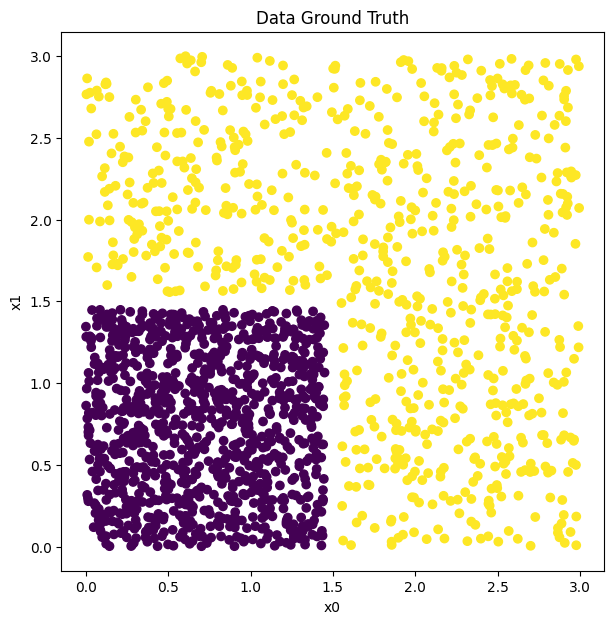

In [196]:
# Lets see what the data looks like
plt.figure(figsize=(7, 7))
plt.scatter(x_train[:, 0].numpy(), x_train[:, 1].numpy(), c=y_train.flatten().numpy())
_ = plt.xlabel("x0")
_ = plt.ylabel("x1")
_ = plt.title("Data Ground Truth")

In [197]:
logistic_linear = nn.Linear(2, 1) 
loss_function = nn.BCEWithLogitsLoss()

# Create our optimizer - lr = 0.1
logistic_optimizer = torch.optim.Adam(logistic_linear.parameters(), lr=0.1)
# Number of times we iterate over the dataset
max_epoch = 100

logistic_loss_log = [] # keep track of the loss values
logistic_acc = [] # keep track of the accuracy 
for epoch in range(max_epoch):
    with torch.no_grad():
        y_test_hat = logistic_linear(x_test)
        
        # The descision boundary is at 0.5 (between 0 and 1) AFTER the sigmoid
        # The input to the Sigmoid function that gives 0.5 is 0!
        # Therefore the descision boundary for the RAW output is at 0!!
        class_pred = (y_test_hat > 0).float()
        logistic_acc.append(float(sum(class_pred == y_test))/ float(y_test.shape[0]))
        
    # Perform a training step
    y_train_hat = logistic_linear(x_train)
    loss = loss_function(y_train_hat, y_train)
    
    logistic_optimizer.zero_grad()
    loss.backward()
    logistic_optimizer.step()

    logistic_loss_log.append(loss.item())
    
print("Accuracy of linear model(GD): %.2f%% " %(logistic_acc[-1]*100))

Exception ignored in: <function tqdm.__del__ at 0x00000244A6087BA0>
Traceback (most recent call last):
  File "c:\Users\Sanele Hlabisa\Desktop\2025\The Complete Pytorch Deep Learning Series!\venv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\Sanele Hlabisa\Desktop\2025\The Complete Pytorch Deep Learning Series!\venv\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Accuracy of linear model(GD): 90.72% 


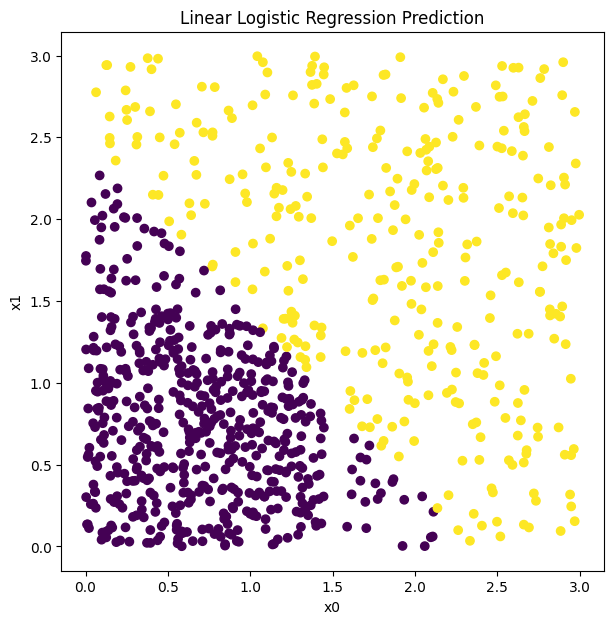

In [198]:
# Lets see what the data looks like
plt.figure(figsize=(7, 7))
plt.scatter(x_test[:, 0].numpy(), x_test[:, 1].numpy(), c=class_pred.flatten().numpy())
_ = plt.xlabel("x0")
_ = plt.ylabel("x1")
_ = plt.title("Linear Logistic Regression Prediction")

In [199]:
# Non-Linear function approximator

In [200]:
# Using the equation 0 = w0*x0 + w1*x1 + w2
# Consider each input dimention intependantly 
# Therefore we have 2 equations 0 = w0*x0 + w1
# -w1/w0 = 1.5
# Pick any w1 and calculate w0

w0 = 1
w1 = -(1.5 * w0)
w_0 = torch.FloatTensor([[w0, 0], [0, w0]])
b_0 = torch.FloatTensor([[w1, w1]])
print("Weights", w_0.numpy())
print("bias", b_0.numpy())

h1 = F.linear(x_train, w_0, bias=b_0)
h2 = torch.sigmoid(h1)

Weights [[1. 0.]
 [0. 1.]]
bias [[-1.5 -1.5]]


Text(0.5, 1.0, 'Sigmoid output')

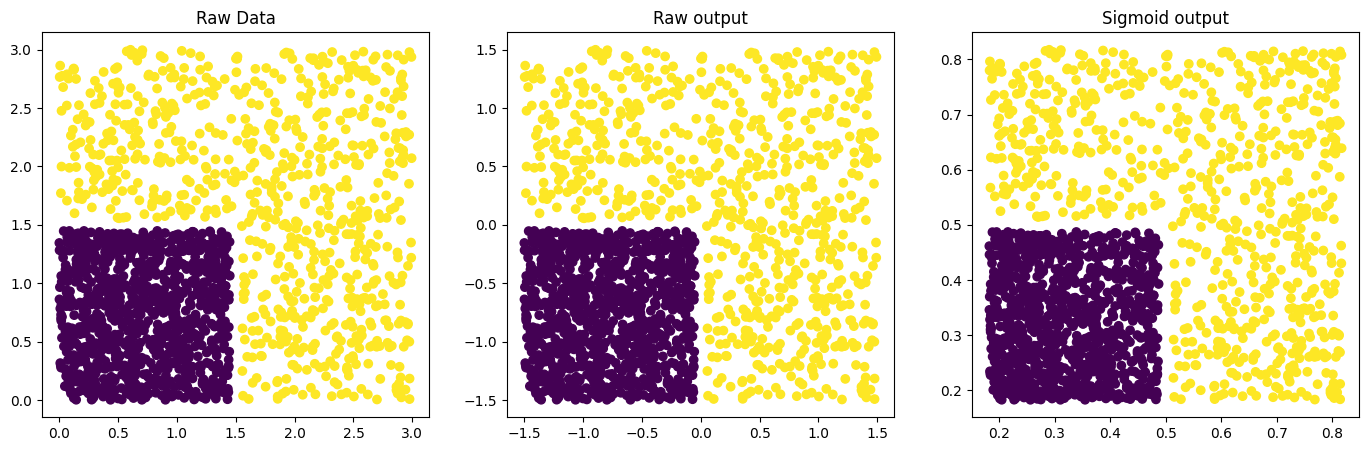

In [201]:
# Plot out the Raw data vs Raw output and Sigmoid output
# What happens as you increase w0???
# Increase w0 untill the data becomes linearly seperable!

plt.figure(figsize=(17, 5))
plt.subplot(131)
plt.scatter(x_train[:, 0].numpy(), x_train[:, 1].numpy(), c=y_train.flatten().numpy())
plt.title("Raw Data")

plt.subplot(132)
plt.scatter(h1[:, 0].numpy(), h1[:, 1].numpy(), c=y_train.flatten().numpy())
plt.title("Raw output")

plt.subplot(133)
plt.scatter(h2[:, 0].numpy(), h2[:, 1].numpy(), c=y_train.flatten().numpy())
plt.title("Sigmoid output")

In [202]:
# Create a line between the points (0, 0.6) and (0.6, 0)
point0 = torch.tensor([0.6, 0])
point1 = torch.tensor([0, 0.6])

w0 = 1
w1 = 1
w2 = -0.6
w_1 = torch.FloatTensor([[w0, w1]])
b_1 = torch.FloatTensor([w2])
print("Weights", w_1.numpy())
print("bias", b_1.numpy())

h3 = F.linear(h2, w_1, bias=b_1)
class_pred = (h3 > 0).float()

# Calculate the accuracy!
acc = float(sum(class_pred == y_train))/ float(y_train.shape[0])
print("Non-linear accuracy %.2f%%" % (acc * 100))

Weights [[1. 1.]]
bias [-0.6]
Non-linear accuracy 64.10%


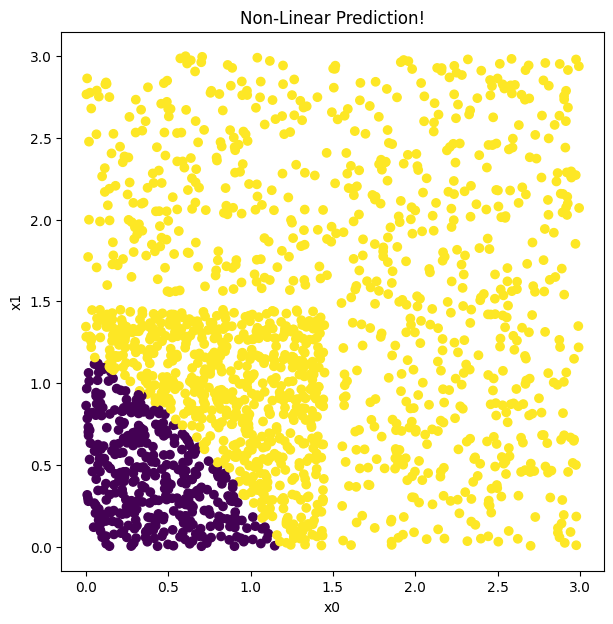

In [203]:

plt.figure(figsize=(7, 7))

plt.scatter(x_train[:, 0].numpy(), x_train[:, 1].numpy(), c=class_pred.flatten().numpy())
_ = plt.xlabel("x0")
_ = plt.ylabel("x1")
_ = plt.title("Non-Linear Prediction!")

In [204]:
# Training Non-Linear Logistic Regression Model with PyTorch

In [205]:
# Recreate the non-linear architecture that we used with Pytorch linear layers!
class NonLinearModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(NonLinearModel, self).__init__() 
        self.linear1 = nn.Linear(input_size, hidden_size)         
        self.linear2 = nn.Linear(hidden_size, output_size) 

    def forward(self, x):
        self.h1 = self.linear1(x)
        self.h2 = torch.sigmoid(self.h1)
        self.h3 = self.linear2(self.h2)
        
        return self.h3

In [206]:
# The parameters of the Neural Network are randomly initialised so we must use gradient decent to find the 
# optimal parameters!

logistic_nonlinear = NonLinearModel(input_size=2, output_size=1, hidden_size=2) 
loss_function = nn.BCEWithLogitsLoss()

# Create our optimizer - lr = 0.1
logistic_optimizer = torch.optim.Adam(logistic_nonlinear.parameters(), lr=1e-2)

logistic_loss_log = [] # keep track of the loss values
logistic_acc = [] # keep track of the accuracy 

In [207]:
# Number of times we iterate over the dataset
max_epoch = 5000

for epoch in trange(max_epoch, desc="Training Epochs"):
    with torch.no_grad():
        y_test_hat = logistic_nonlinear(x_test)
        
        # The descision boundary is at 0.5 (between 0 and 1) AFTER the sigmoid
        # The input to the Sigmoid function that gives 0.5 is 0!
        # Therefore the descision boundary for the RAW output is at 0!!
        class_pred = (y_test_hat > 0).float()
        logistic_acc.append(float(sum(class_pred == y_test))/ float(y_test.shape[0]))
        
    # Perform a training step
    y_train_hat = logistic_nonlinear(x_train)
    loss = loss_function(y_train_hat, y_train)
    
    logistic_optimizer.zero_grad()
    loss.backward()
    logistic_optimizer.step()

    logistic_loss_log.append(loss.item())
    
print("Accuracy of Non-linear model(GD): %.2f%% " %(logistic_acc[-1]*100))

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

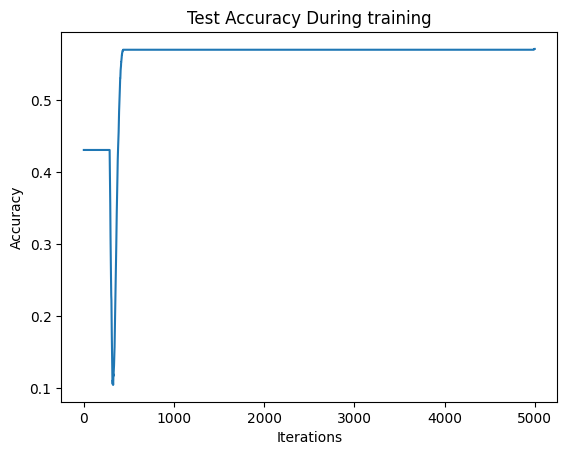

In [186]:
plt.plot(logistic_acc)
_ = plt.xlabel("Iterations")
_ = plt.ylabel("Accuracy")
_ = plt.title("Test Accuracy During training")

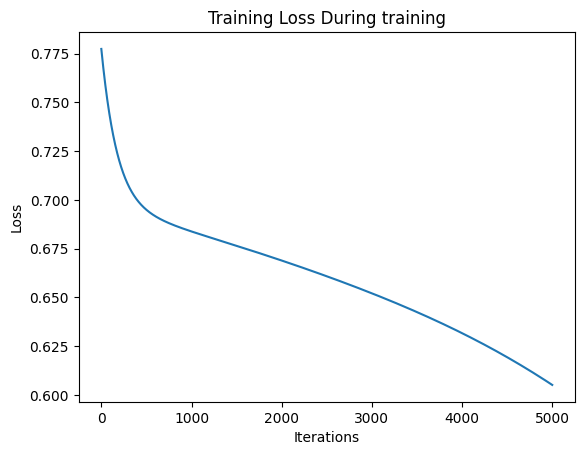

In [187]:
plt.plot(logistic_loss_log)
_ = plt.xlabel("Iterations")
_ = plt.ylabel("Loss")
_ = plt.title("Training Loss During training")

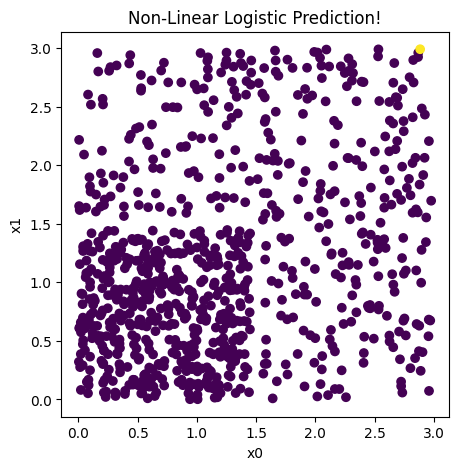

In [188]:
with torch.no_grad():
    y_test_hat = logistic_nonlinear(x_test)
    class_pred = (y_test_hat > 0).float()
    
plt.figure(figsize=(5, 5))    
plt.scatter(x_test[:, 0].numpy(), x_test[:, 1].numpy(), c=class_pred.flatten().numpy())
_ = plt.xlabel("x0")
_ = plt.ylabel("x1")
_ = plt.title("Non-Linear Logistic Prediction!")

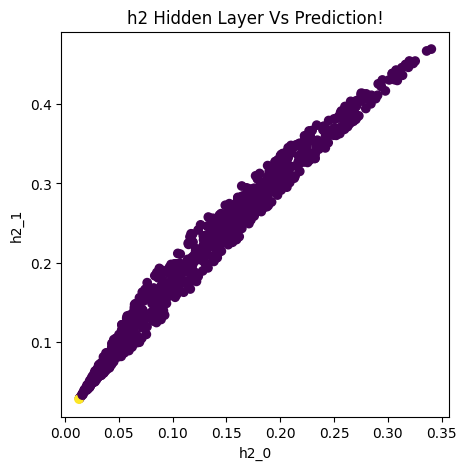

In [189]:
plt.figure(figsize=(5, 5))
plt.scatter(logistic_nonlinear.h2[:, 0].numpy(), 
            logistic_nonlinear.h2[:, 1].numpy(), 
            c=class_pred.flatten().numpy())

_ = plt.xlabel("h2_0")
_ = plt.ylabel("h2_1")
_ = plt.title("h2 Hidden Layer Vs Prediction!")

In [191]:
logistic_nonlinear.linear2.bias

Parameter containing:
tensor([0.0504], requires_grad=True)